# Determining velocity by intensity measurement

## Finding intensity pater of 3x3 pixels 

In [1]:
import numpy as np
from itertools import combinations, product
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from scipy.interpolate import NearestNDInterpolator

In [2]:
np.arange(9).reshape((3, 3))

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

## Random intensity patern

In [5]:
intensity = np.random.rand(9)

Check for collisions

In [264]:
collisions = defaultdict(list)

for mask in product((True, False), repeat=len(intensity)):
    mask = np.array(mask)
    total_intensity = intensity[mask].sum()
    collisions[total_intensity].append(mask)

In [273]:
def rounding_vs_number_of_collisions(intensity):
    
    decimals = np.arange(2, 9)
    
    nunique_elements = []
    
    for dec in decimals:
        rounded_intensity = np.round(intensity, decimals=dec)
        
        nunique_elements.append(
            len(
                {
                    rounded_intensity[np.array(mask)].sum() for mask in product((True, False), repeat=len(intensity))
                }
            )
        )
    
    plt.plot(decimals, nunique_elements, '*-')
    plt.show()

    print(max(nunique_elements))

512


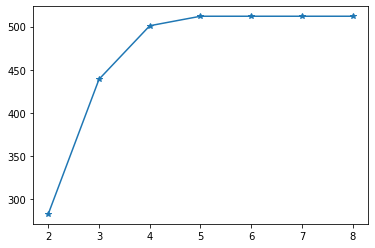

In [272]:
rounding_vs_number_of_collisions(intensity)

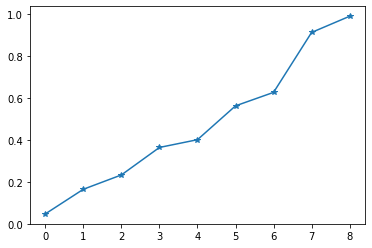

In [276]:
plt.plot(np.sort(intensity), '*-')

## Generating random linear trajectories in rectangle

Text(0.5, 1.0, 'Random trjectories')

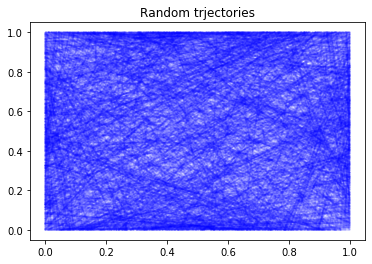

In [239]:
random_traj = []

for _ in range(2000):
    # place 4 random points on all the sides of rectangle 
    rand_points = [
        (random.random(), 0.), (1., random.random()), (random.random(), 1.), (0., random.random())
    ]

    # randomly select two of these points
    initial_point, final_point = random.sample(rand_points, k=2)
    
    initial_point = np.array(initial_point)
    final_point = np.array(final_point)
    
    # random duration of motion along the trajectory
    duration = random.random()
    
    distance = np.linalg.norm(initial_point - final_point)
    
    # assume spacial resolution of 1e-2
    num_points = distance / 0.01
    
    tau = np.linspace(0., 1., num_points)[:, np.newaxis]
    
    trajectory = initial_point + tau * (final_point - initial_point)
    
    assert len(trajectory), 'trajectory must not be empty. adjust spacial resolution'
    
    #
    random_traj.append(
        (duration, trajectory)
    )
    
    plt.plot(
        (initial_point[0], final_point[0]),
        (initial_point[1], final_point[1]), 
        'b',
        alpha=0.1,
        # c=plt.cm.viridis(duration),
    )

plt.title('Random trjectories')

In [191]:
# max(random_traj), min(random_traj)

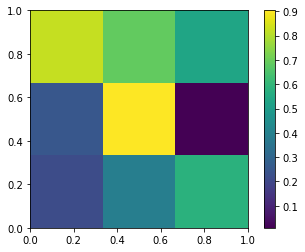

In [107]:
x_interp, y_interp = np.meshgrid(np.linspace(1/6., 5/6., 3), np.linspace(1/6., 5/6., 3))

x_interp = x_interp.reshape(-1)
y_interp = y_interp.reshape(-1)

f = NearestNDInterpolator((x_interp, y_interp), intensity)

X, Y = np.meshgrid(np.linspace(0., 1., 30), np.linspace(0., 1., 30))

plt.imshow(f(X, Y), extent=[0, 1, 0, 1], origin='lower')
plt.colorbar()
plt.show()

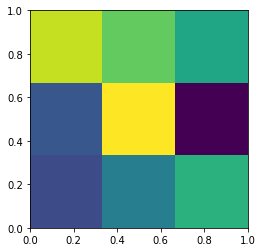

In [108]:
plt.imshow(intensity.reshape(3,3), extent=[0, 1, 0, 1], origin='lower')

In [72]:


def nunique(individual):
    
    total_intensity = set()
    
    for r in range(1, len(individual) + 1):
        """
        for comb in combinations(individual, r):
            
            val = sum(comb[:-1])
            last = comb[-1]
            
            total_intensity.update(
                round(val + k * last / 5.) for k in range(1, 5)
            )
        """
        total_intensity.update(
            sum(comb) for comb in combinations(individual, r)
        )
    
    return len(total_intensity),


In [192]:
def round_sig_dig(x, significant_digits=3):
    """
    rounding to significant digits
    """
    num_digits = np.ceil(np.log10(x))
    
    pow10 = 10 ** num_digits
    
    return np.round(x / pow10, significant_digits) * pow10

## Using genetic algorithm to find the algorithm with least collisions

In [215]:
import array
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='B', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_bool", random.randrange, 0, 255)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 9)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

"""
def nunique(individual):
    
    total_intensity = set()
    
    for r in range(1, len(individual) + 1):
        total_intensity.update(
            sum(comb) for comb in combinations(individual, r)
        )

    return len(total_intensity),
"""
def nunique(individual):
    
    # interpolating
    f = NearestNDInterpolator((x_interp, y_interp), np.array(individual))
     
    # calculating collisions
    total_intensity = np.array(
           [duration * f(trajectory).sum() for duration, trajectory in random_traj]
    )
    
    total_intensity /= total_intensity.max()
    np.round(total_intensity, out=total_intensity, decimals=3)
    return len(np.unique(total_intensity)),
    #print(max(total_intensity), min(total_intensity))
        
    #return len(total_intensity),

toolbox.register("evaluate", nunique)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=255, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

#random.seed(64)
    
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [216]:

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, 
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg   	std    	min	max
0  	300   	656.04	50.8605	488	771
1  	180   	689.79	36.5755	565	766
2  	153   	717.507	24.3437	633	768
3  	185   	729.207	28.2156	616	796
4  	185   	744.357	26.6385	627	803
5  	190   	757.87 	20.9461	648	806
6  	165   	769.15 	20.219 	668	808
7  	161   	778.567	18.7947	661	808
8  	176   	785.427	14.6401	713	808
9  	172   	792.82 	11.806 	747	808
10 	178   	794.81 	13.9664	733	808
11 	166   	800.183	13.3655	732	813
12 	174   	802.083	13.0186	693	815
13 	184   	803.75 	11.04  	743	817
14 	197   	805.073	10.4996	729	817
15 	195   	807.133	9.03266	742	817
16 	189   	807.99 	12.1184	720	817
17 	171   	810.667	11.2233	751	817
18 	180   	813.04 	12.0238	695	817
19 	161   	813.573	12.1449	718	817
20 	177   	813.497	13.9096	716	817


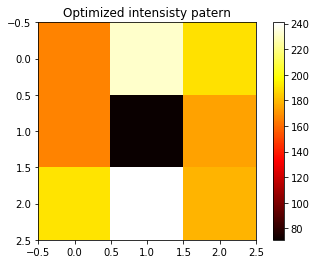

In [217]:
plt.title('Optimized intensisty patern')
plt.imshow(
    np.array(hof.items[0]).reshape(3, 3),
    cmap='hot'
)
plt.colorbar()

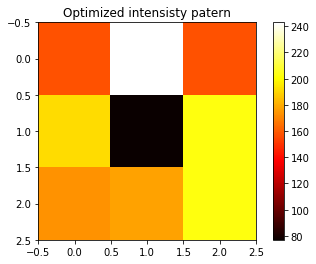

In [201]:
plt.title('Optimized intensisty patern')
plt.imshow(
    np.array(hof.items[0]).reshape(3, 3),
    cmap='hot'
)
plt.colorbar()

In [202]:
hof.items[0]

Individual('B', [158, 243, 158, 192, 77, 203, 174, 178, 203])

In [263]:
def analyze(individual):
    
    # interpolating
    f = NearestNDInterpolator((x_interp, y_interp), np.array(individual))
     
    # calculating collisions
    total_intensity = np.array(
           [duration * f(trajectory).sum() for duration, trajectory in random_traj]
    )
    
    total_intensity /= total_intensity.max()
    np.round(total_intensity, out=total_intensity, decimals=3)
    

    for colour, (duration, trajectory) in zip(total_intensity, random_traj): 
        if colour > 0.3: continue
        plt.plot(
            (trajectory[0, 0], trajectory[-1, 0]),
            (trajectory[0, 1], trajectory[-1, 1]), 
            'b',
            alpha=0.2,
            c=plt.cm.viridis(colour),
        )
    
    plt.show()
    
    # plt.hist(total_intensity)

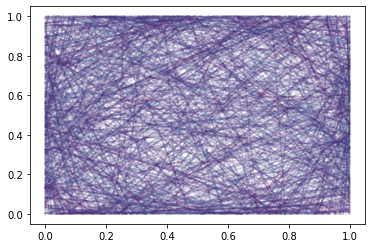

In [264]:
#np.sum(nunique(hof.items[0]) == 0)
analyze(hof.items[0])


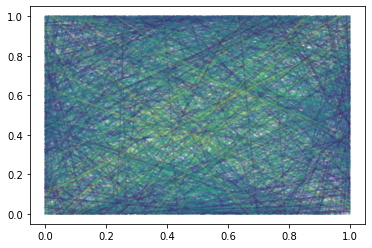

In [256]:
analyze(np.ones(9))

(array([187., 218., 218., 214., 187., 183., 198., 206., 182., 207.]),
 array([9.46551588e-04, 1.00848207e-01, 2.00749862e-01, 3.00651518e-01,
        4.00553173e-01, 5.00454829e-01, 6.00356484e-01, 7.00258140e-01,
        8.00159795e-01, 9.00061450e-01, 9.99963106e-01]),
 <a list of 10 Patch objects>)

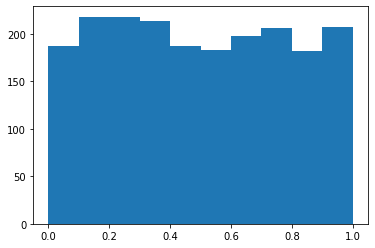

In [265]:
plt.hist([x[0] for x in random_traj])

In [244]:
random_traj[0][1][:,0]

array([0.        , 0.01020849, 0.02041699, 0.03062548, 0.04083397,
       0.05104247, 0.06125096, 0.07145945, 0.08166795, 0.09187644,
       0.10208493, 0.11229342, 0.12250192, 0.13271041, 0.1429189 ,
       0.1531274 , 0.16333589, 0.17354438, 0.18375288, 0.19396137,
       0.20416986, 0.21437836, 0.22458685, 0.23479534, 0.24500384,
       0.25521233, 0.26542082, 0.27562932, 0.28583781, 0.2960463 ,
       0.3062548 , 0.31646329, 0.32667178, 0.33688027, 0.34708877,
       0.35729726, 0.36750575, 0.37771425, 0.38792274, 0.39813123,
       0.40833973, 0.41854822, 0.42875671, 0.43896521, 0.4491737 ,
       0.45938219, 0.46959069, 0.47979918, 0.49000767, 0.50021617,
       0.51042466, 0.52063315, 0.53084164, 0.54105014, 0.55125863,
       0.56146712, 0.57167562, 0.58188411, 0.5920926 , 0.6023011 ,
       0.61250959, 0.62271808, 0.63292658, 0.64313507, 0.65334356,
       0.66355206, 0.67376055, 0.68396904, 0.69417754, 0.70438603,
       0.71459452, 0.72480302, 0.73501151, 0.74522   , 0.75542

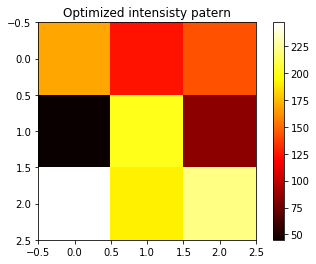

In [100]:
plt.title('Optimized intensisty patern')
plt.imshow(
    np.array(hof.items[0]).reshape(3, 3),
    cmap='hot'
)
plt.colorbar()

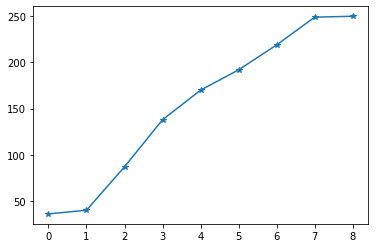

In [223]:
plt.plot(np.sort(hof.items[0]), '*-')

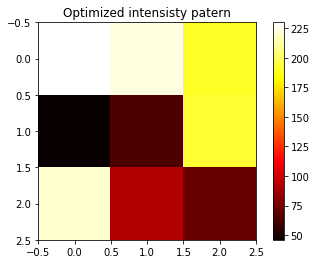

In [104]:
plt.title('Optimized intensisty patern')
plt.imshow(
    np.array(hof.items[0]).reshape(3, 3),
    cmap='hot'
)
plt.colorbar()

In [152]:
nunique(hof.items[0])

4599


(1512,)

In [135]:
hof.items[0]

Individual('B', [130, 191, 240, 67, 248, 5, 244, 24, 12])

In [130]:
2 ** 10

1024

In [150]:
len(list(range(1, 10)))

9

In [161]:
np.round(255/1000, decimals=3)

0.255